# Multivariate Time Series Random-Forests

In multivariate time series classification problems, one is interested in classifying a C x T array of data, where C is the number of time series (denoted as channels) and T is the number of time points (based on the sampling rate). 

## Multivariate Timeseries - Manifold Forests (MT-MORF)
Here, MT-MORF is in essence extending this idea from the image domain to the time series domain. Rather then taking contiguous kernel patches over the data array, we are taking kernel patches that are discontiguous along the "C" axis over the data array.

Visual Examples of Contiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.saama.com%2Fdifferent-kinds-convolutional-filters%2F&psig=AOvVaw1KSgQ0V39eN9S_JB6JAoGc&ust=1584819248892000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCMCO4_rlqegCFQAAAAAdAAAAABAD

Visual Examples of Discontiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.mdpi.com%2F2076-3417%2F10%2F5%2F1727%2Fhtm&psig=AOvVaw39o_oj3W8Lkbn-Pq6nbboy&ust=1584819310634000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNDuj5TmqegCFQAAAAAdAAAAABAD

In [1]:
cd ../../../../

/home/adam2392/Documents/RerF


In [2]:
!pip install statsmodels

     |████████████████████████████████| 8.7MB 5.1MB/s eta 0:00:01
     |████████████████████████████████| 26.1MB 52.5MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ea/0c/5f61f1a3d4385d6bf83b83ea495068857ff8dfb89e74824c6e9eb63286d8/patsy-0.5.1-py2.py3-none-any.whl
     |████████████████████████████████| 10.0MB 47.8MB/s eta 0:00:01
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/home/adam2392/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/home/adam2392/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/adam2392/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012,

In [4]:
import pandas as pd
from scipy import stats
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.vector_ar.var_model import VARProcess

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [14]:
def generate_ar_samples(cls=0, n_steps=1000, k=1):
    """
    Generate multivariate time-series for 3 channsl of length n_samples
    from a vector AR(1) model. Noise channels are interleaved between
    the vector sequences.

    VAR(1) Model: 
    y(t+1) = Ay(t) + Bu(t) + err(t)

    For now, we ignore exogenous variables, i.e. B = 0, and assume
    uncorrelated errors.
    """
    n_chs = 3
    n_noise_chs = 3

    # scale data along time w/ normalization
    scaler = StandardScaler()
    
    # signal that separates binary classes
    if cls == 0:
        A = np.array([[
            [  0.5,  0.5*k, 0.7*k],
            [0.3*k, -0.8, -0.15*k],
            [0.5*k,  0.2*k, -0.6]
        ]])
        
#         A = np.array([
#             [  0.5,  0.5*k, 0.7*k],
#             [0.5*k, -0.8, -0.15*k],
#             [0.7*k,  -0.15*k, -0.6]
#         ])
    elif cls == 1:
        A = np.array([[
            [0.5,    0,    0],
            [  0, -0.8,    0],
            [  0,    0, -0.6]
        ]])

    B = np.zeros((n_chs, n_chs))

    A_eigvals = np.linalg.eigvals(A)
    A_spec_rad = np.max(np.abs(A_eigvals))

    # TODO: Figure out how to best set error relative to A matrix
    err_cov = 0.05 * A_spec_rad * np.identity(n_chs)
    
    # generate vector autoregressive process and simulate forward
    var = VARProcess(A, B, err_cov, _params_info={'k_trend': 0})
    y = var.simulate_var(steps=n_steps).T
    assert y.shape == (n_chs, n_steps)

    y_noise = np.random.random((n_noise_chs, n_steps)) * A_spec_rad

    y = np.vstack((
        y[0,:], y_noise[0,:],
        y[1,:], y_noise[1,:],
        y[2,:], y_noise[2,:]
    ))
    
    # normalize along the time domain
    # y = scaler.fit_transform(y.T).T
    
    return y

In [15]:
def simulate_data(cov_factor):
    np.random.seed(1234)

    # length of data sequence
    ns = np.array([50,100,200,
                   400,1000,2000
                  ])
    test_size = 0.5  # size of the test data

    # simulated data parameters
    T = 100
    nchs = 6

    # initialize data structures for train/test data
    X_train, Y_train = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))
    X_test, Y_test = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))

    # simulate over varying sizes of data sequence
    for n in ns:
        y = []
        X = []

        # generate correlated multi-variate time series
        for i in range(n):
            _x = generate_ar_samples(cls=0, n_steps=T, k=cov_factor)
            X.append(_x)
            y.append(0)
        for i in range(n):
            _x = generate_ar_samples(cls=1, n_steps=T, k=cov_factor)
            X.append(_x)
            y.append(1)
        X = np.array(X)
        y = np.array(y)

        # perform training test split
        _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                            test_size=test_size, 
                                                            random_state=42)
        X_train = np.vstack((X_train, _X_train))
        Y_train = np.hstack((Y_train, _y_train))
        X_test = np.vstack((X_test, _X_test))
        Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, Y_train, X_test, Y_test

In [16]:
T = 100
ns = np.array([50,100,200,400,1000,2000])
nchs = 6
test_size = 0.5
seed = 1234

# initialize data structures for train/test data
X_train, Y_train = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))
X_test, Y_test = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))

for n in ns:
    X, y = [], []

    # generate correlated multi-variate time series
    for i in range(n):
        _x = generate_ar_samples(cls=0, n_steps=T)
        X.append(_x)
        y.append(0)
    for i in range(n):
        _x = generate_ar_samples(cls=1, n_steps=T)
        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)
    
    # normalize over time per channel
    

    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=seed)
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape, Y_train.shape, X_test.shape)

(3750, 6, 100)
(3750, 600) (3750,) (3750, 600)


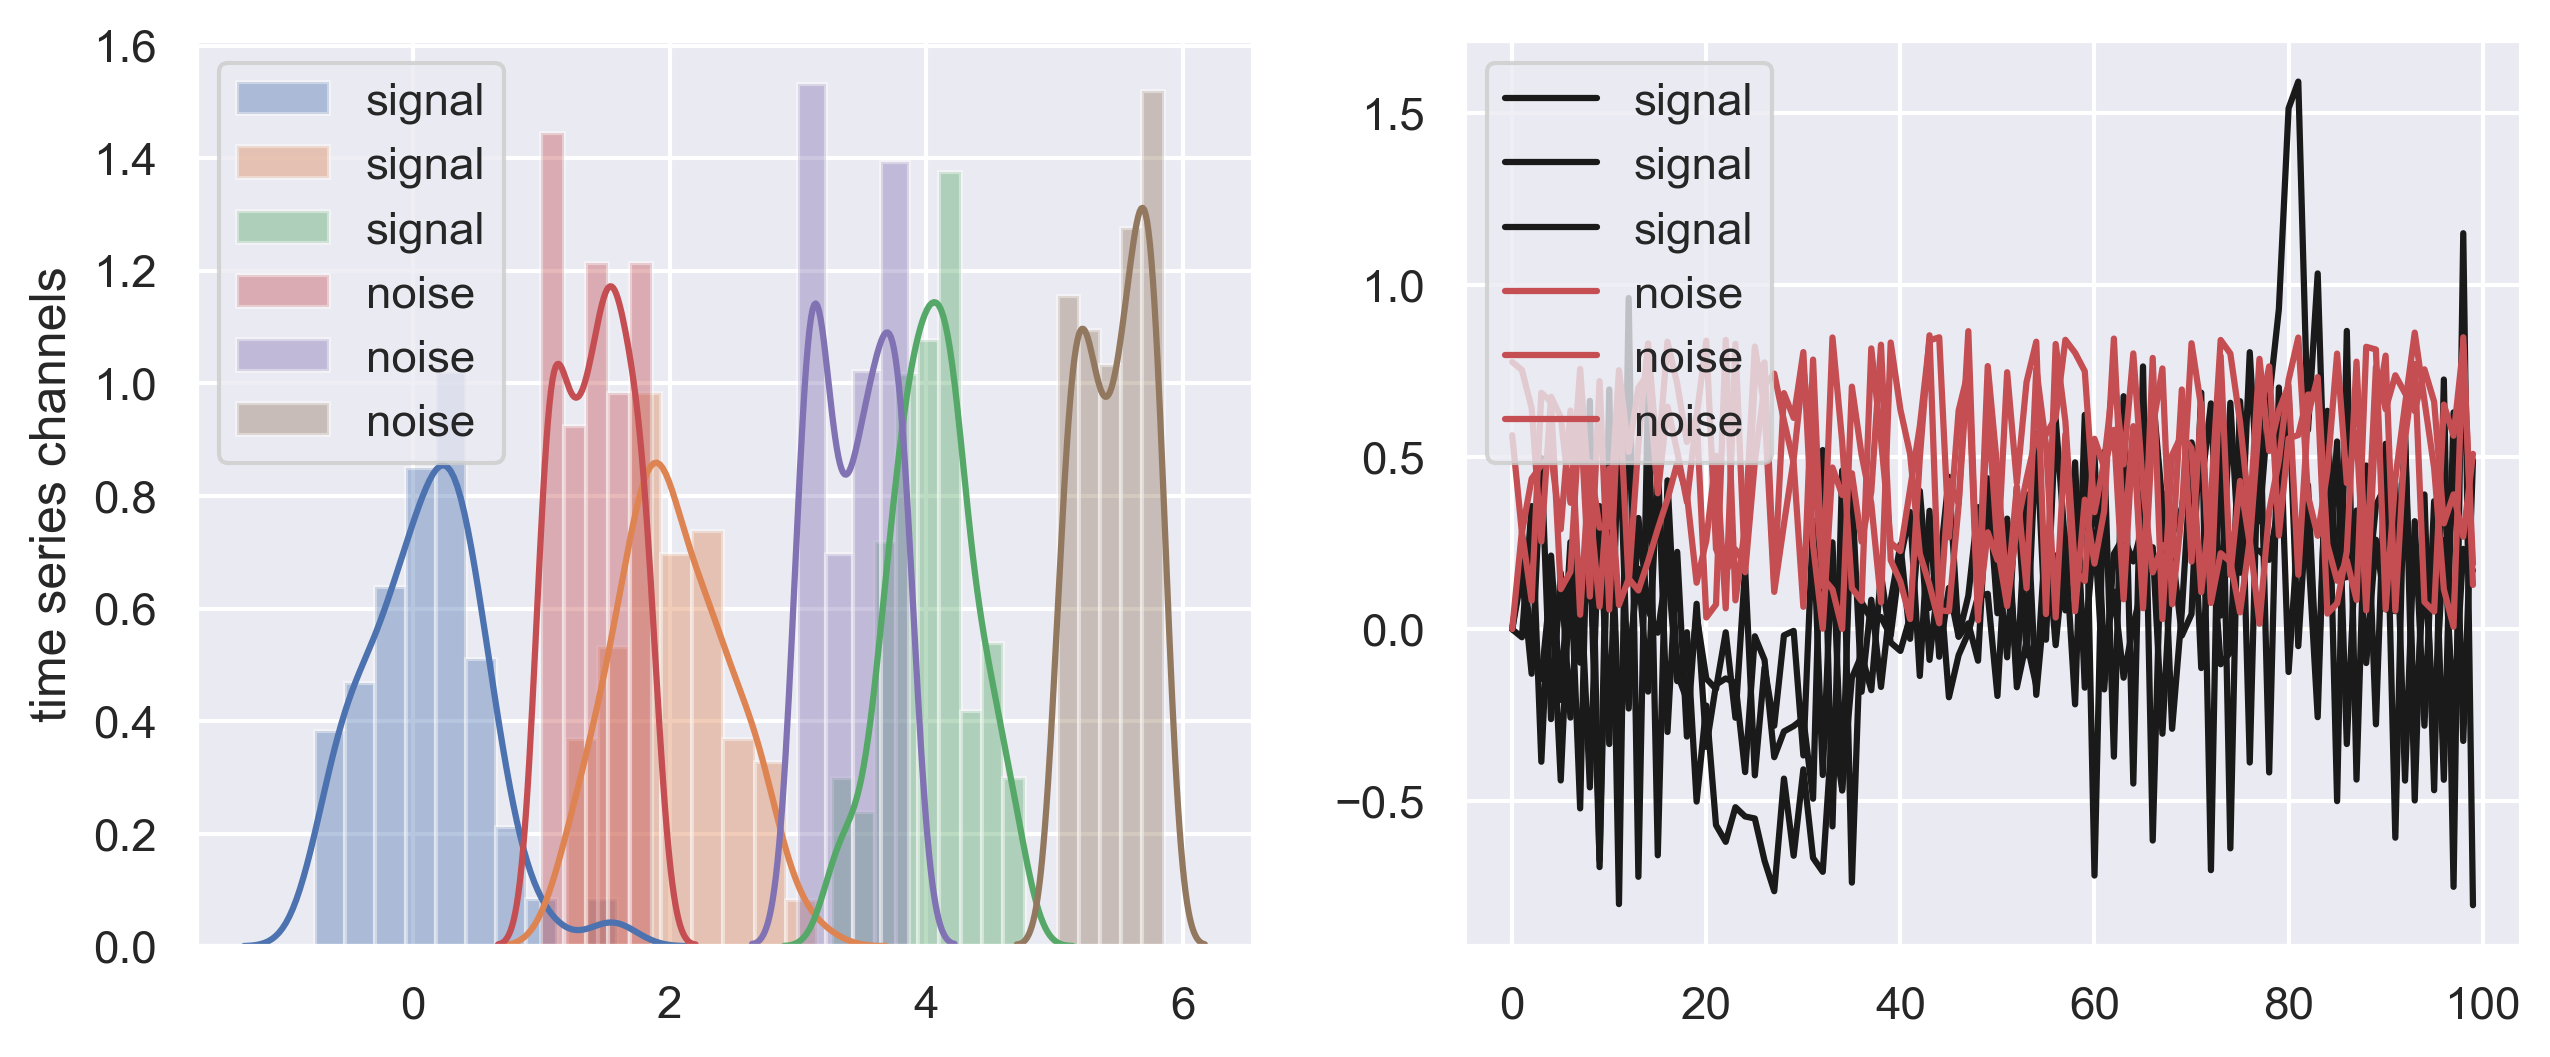

In [17]:
# Plot various projections of the samples.
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
for i in [0, 2, 4]:
    sns.distplot(X_train[0, i*T:T*(i+1)]+np.r_[i], ax=ax, label='signal')
for i in [1, 3, 5]:
    sns.distplot(X_train[0, i*T:T*(i+1)]+np.r_[i], ax=ax, label='noise')
ax.set_ylabel('time series channels')
ax.legend()
# plt.axis('equal')
plt.grid(True)

ax = axs[1]
for i in [0, 2, 4]:
    ax.plot(X_train[0, i*T:T*(i+1)], 'k', label='signal')
for i in [1, 3, 5]:
    ax.plot(X_train[0, i*T:T*(i+1)], 'r', label='noise')
ax.legend()
plt.show()

In [9]:
## Setup for run
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red", "MT-MORF": "orange"}

ncores=1
num_runs=1
n_est=100  # number of estimators

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=T,
                    patch_height_max=3,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=5
                   ),
    rerfClassifier(projection_matrix="MT-MORF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=T,
                    patch_height_max=3,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=5
                   )
    ]

# Run Classification Comparison Experiment

Perform a classification over all models, and then summarize in a figure

In [10]:
runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]
print("About to run", len(runList), "clf experiments")
print(n)
print(ns)
print(len(classifiers))
print(num_runs)

About to run 48 clf experiments
2000
[  50  100  200  400 1000 2000]
8
1


In [18]:
# Train each classifier on each dataset size, then test
# Prep output file:
fname = './mt-morf_ar_experiment.csv'
f = open(fname, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

for n, clf, iteration in tqdm(runList):
    # print(clf)
    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[-1]).T
    if X_test.ndim == 3:
        X_test = X_test.reshape(-1, X_test.shape[-1]).T
    X = X_train[:n]
    y = Y_train[:n]

    trainStartTime = time.time()
    clf[0].fit(X, y)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(out, Y_test).astype(int))


    ####("variable,Lhat,trainTime,testTime,iterate")
    f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
    f.flush()

f.close()

100%|██████████| 48/48 [02:43<00:00,  3.40s/it]


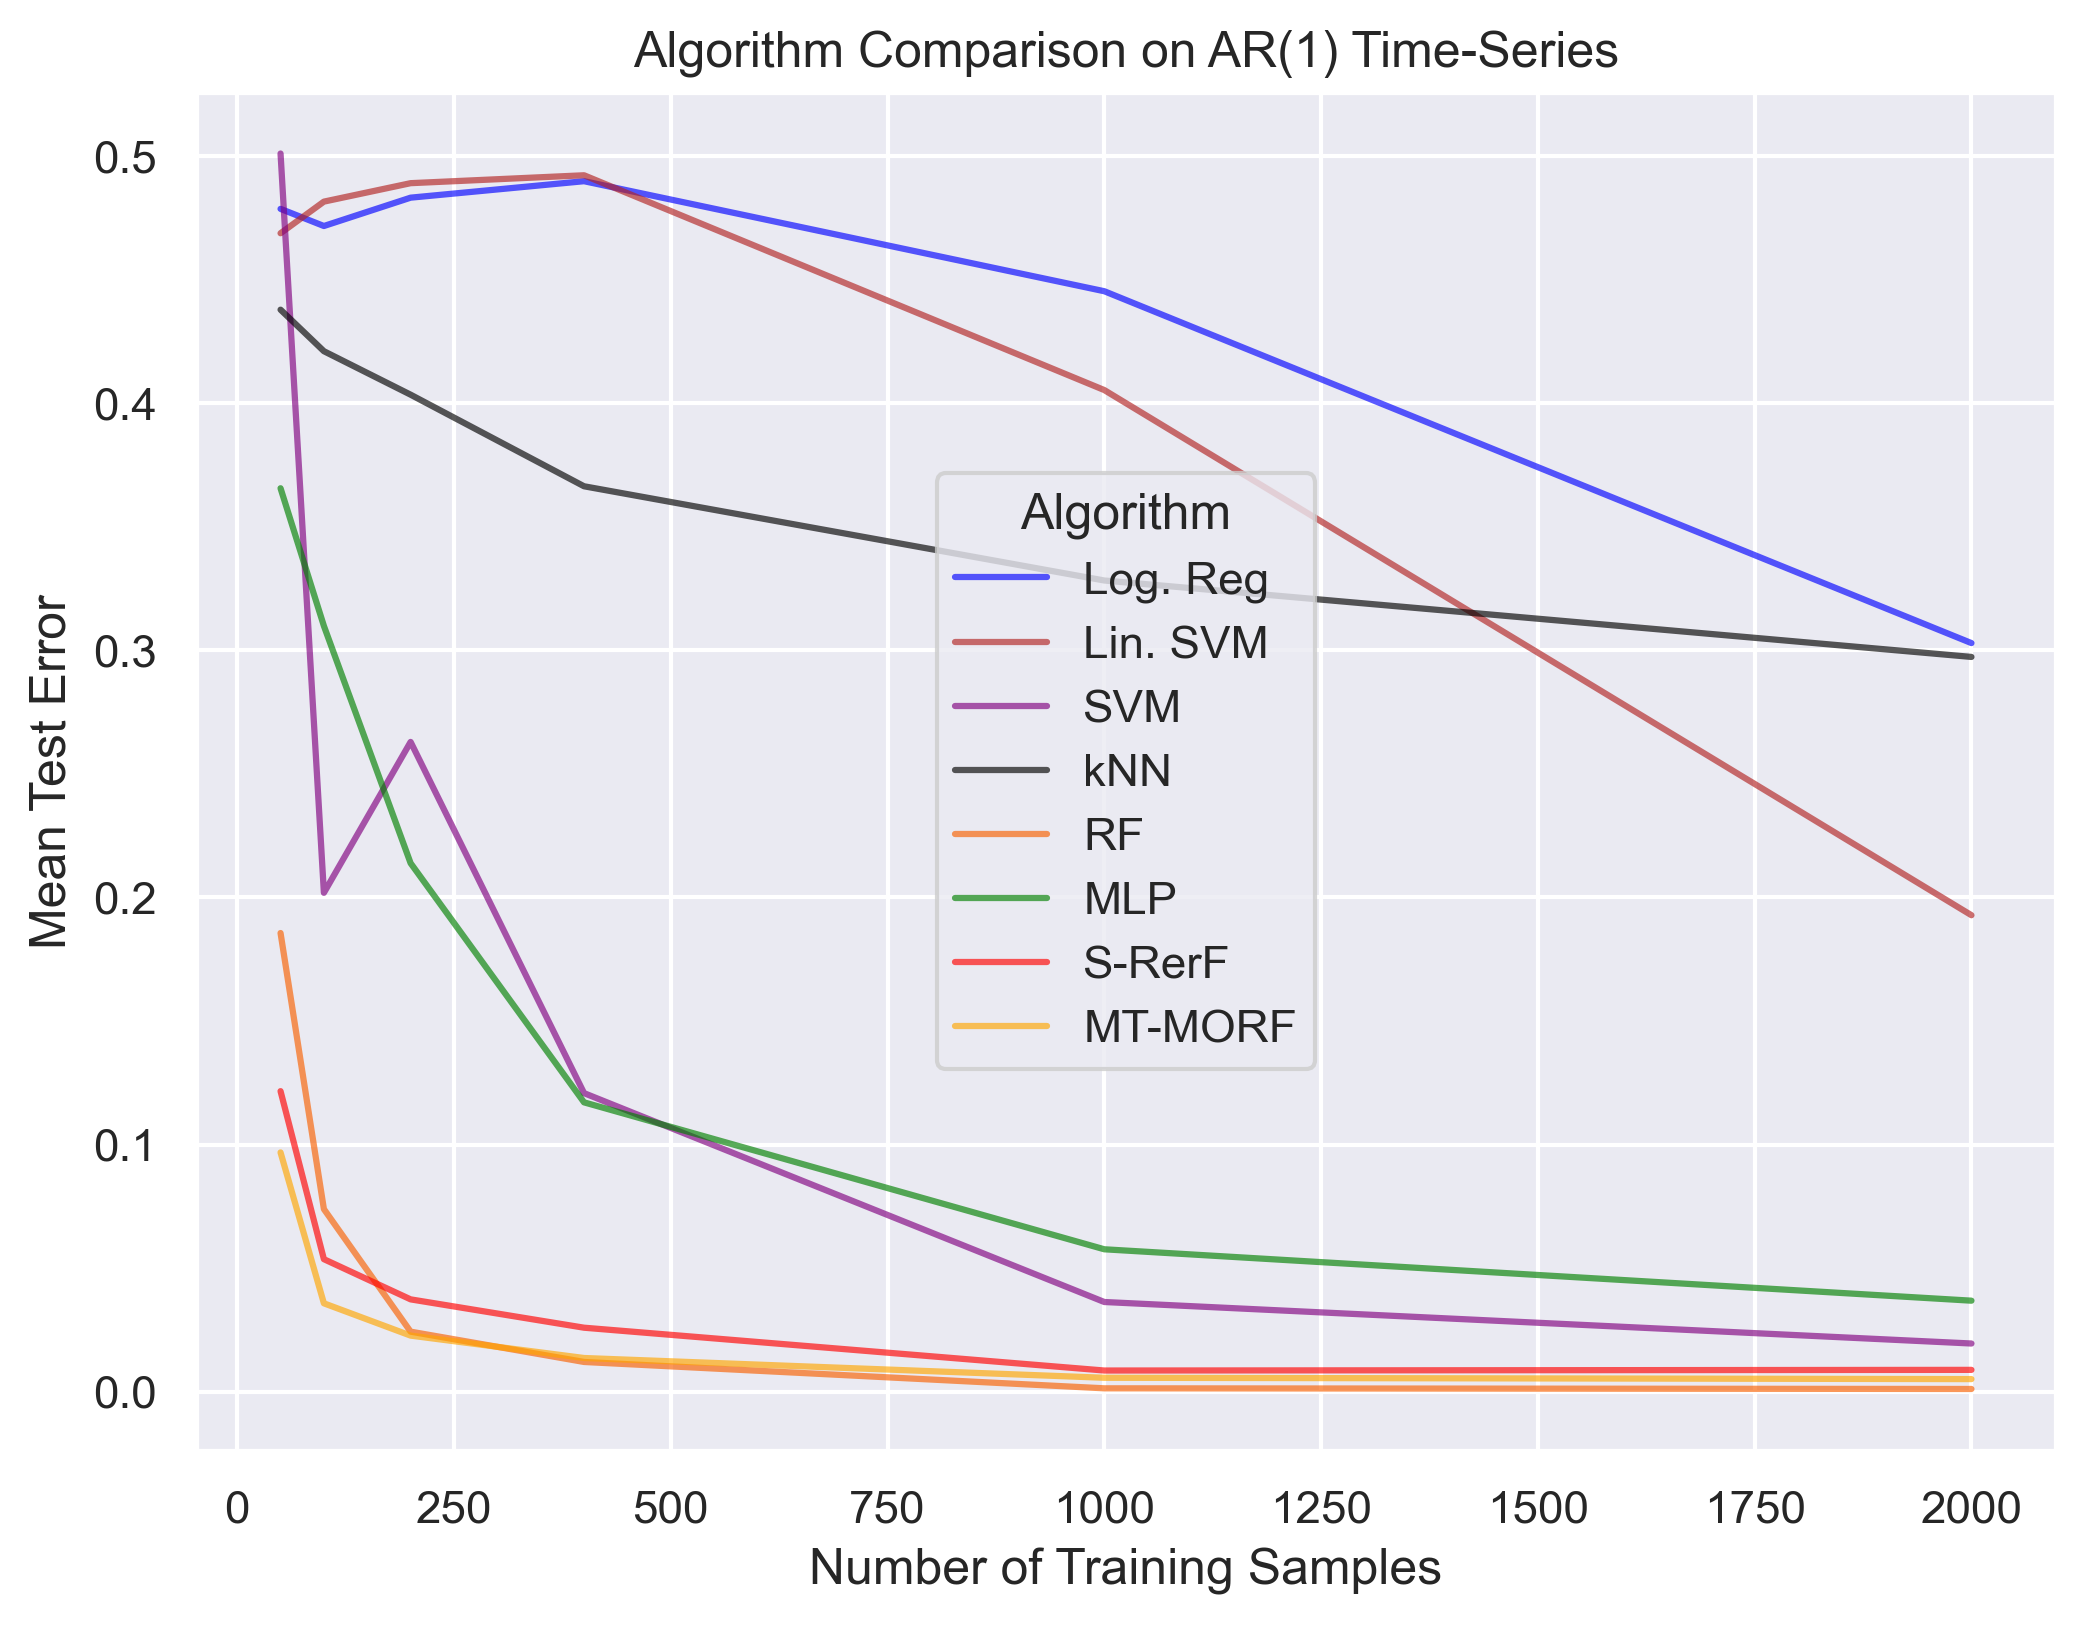

In [19]:
dat = pd.read_csv(fname)

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):
        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')
ax.legend(loc='best',title='Algorithm')
ax.set_title('Algorithm Comparison on AR(1) Time-Series')
ax.set_ylabel('Mean Test Error')
ax.set_xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()

# Experiment over the degreee of cross-correlation

In [ ]:
exp_cov_factors = [1e-5, 0.1, 0.5, 0.75, 0.9]
for cov_factor in exp_cov_factors:
    X_train, y_train, X_test, y_test = simulate_data(cov_factor)
    
    # Train each classifier on each dataset size, then test
    # Prep output file:
    fname = f'./mt-morf_mvar_experiment_covfactor{cov_factor}.csv'
    f = open(fname, 'w+')
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    f.flush()

    for n, clf, iteration in tqdm(runList):
        # print(clf)
        if X_train.ndim == 3:
            X_train = X_train.reshape(-1, X_train.shape[-1]).T
        if X_test.ndim == 3:
            X_test = X_test.reshape(-1, X_test.shape[-1]).T
        X = X_train[:n]
        y = Y_train[:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()
    f.close()

 96%|█████████▌| 46/48 [01:02<00:09,  4.86s/it]

In [ ]:
for cov_factor in exp_cov_factors:
    X_train, y_train, X_test, y_test = simulate_data(cov_factor)
    
    # Train each classifier on each dataset size, then test
    # Prep output file:
    fname = f'./mt-morf_mvar_experiment_covfactor{cov_factor}.csv'

    dat = pd.read_csv(fname)

    d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

    k = 0
    for ni in np.unique(dat['n']):
        for cl in np.unique(dat['classifier']):

            tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

            list(tmp.mean())
            d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
            k += 1


    sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
    fig, ax = plt.subplots(figsize = (8,6))

    for key in names.keys():
        grp = d1[d1['classifier'] == key]
        ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
                c = names[key], alpha =0.65)
        #ax.set_yscale('log')

    plt.legend(loc='best',title='Algorithm')
    plt.title(f'Algorithm Comparison Covariance Factor {cov_factor}')
    plt.ylabel('Mean Test Error')
    plt.xlabel('Number of Training Samples')
    #plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
    plt.show()